# Training a lot of models initialized via LP method

There will be some amount of code duplication between this and investigation.ipynb, and the code is *rough* in places. For now, just getting it all to run is good enough.

In [1]:
import math
import time

from direct_helpers import *

from scipy.optimize import linprog
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision.datasets import MNIST


In [2]:
def get_mnist_lp_model():
    """
    Get an MnistReluCountModel with weights initialized by LP method

    This isn't the prettiest, but it'll do.
    """
    loader = DataLoader(MNIST('images/', train=True, download=True,
                                   transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
                                   ])),
                              batch_size=1, shuffle=True, pin_memory=False)
    opt_model = MnistReluCountModel()
    in_size = 784
    out_size = 750
    
    c_initials= []
    for _ in range(out_size):
        c_initials.append(torch.flatten(get_avg_MNIST(loader=loader, sample_size=1), 0) * -1) # linprog minimizes, we want to maximize
    opt_model.fc1.weight = linprog_parameter(c_initials, in_size)

    
    in_size = out_size
    out_size = 320
    
    relu = nn.ReLU()
    c2_samples = []
    for _ in range(out_size):
        rand_sample = torch.flatten(get_avg_MNIST(loader=loader, sample_size=1), 0) # get a random sample
        sample = relu(opt_model.fc1(rand_sample)) * -1 # pass through layer 1, then scale by -1 for LP
        c2_samples.append(sample)
    opt_model.fc2.weight = linprog_parameter(c2_samples, in_size)

    in_size = out_size
    out_size = 50
    
    c3_samples = []
    for _ in range(out_size):
        rand_sample = torch.flatten(get_avg_MNIST(loader=loader, sample_size=1), 0) # get a random sample
        sample = relu(opt_model.fc1(rand_sample)) # pass through layer 1
        sample = relu(opt_model.fc2(sample)) * -1 # pass through layer 2, then scale by -1 for LP
        c3_samples.append(sample)
    opt_model.fc3.weight = linprog_parameter(c3_samples, in_size)

    in_size = out_size
    out_size = 10
    
    c4_samples = []
    for _ in range(out_size):
        rand_sample = torch.flatten(get_avg_MNIST(loader=loader, sample_size=1), 0) # get a random sample
        sample = relu(opt_model.fc1(rand_sample)) # pass through layer 1
        sample = relu(opt_model.fc2(sample)) # pass through layer 2
        sample = relu(opt_model.fc3(sample)) * -1 # pass through layer 3, then scale by -1 for LP
        c4_samples.append(sample)
    opt_model.fc4.weight = linprog_parameter(c4_samples, in_size)

    return opt_model

In [3]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    total_loss = 0
    batches = 0
    
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        batches += 1
        
    return total_loss / batches


def test_loop(dataloader, model, loss_fn, quiet=False):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    correct = 0
    
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for (X, y) in dataloader:
            out = model(X)
            test_loss += loss_fn(out, y).item()
            pred = out.data.max(1, keepdim=True)[1]
            correct += pred.eq(y.data.view_as(pred)).sum().item()

    test_loss /= num_batches
    accuracy = 100.0 * correct / len(dataloader.dataset)
    if not quiet:
        print(f"Avg loss: {test_loss:>8f}")
        print(f"Accuracy: {correct}/{len(dataloader.dataset)} = {accuracy}")
        print()
    return test_loss, accuracy

In [4]:
class TrainingResults():
    def __init__(self, train_losses, test_losses, test_accs, init_zeros, trained_zeros):
        self.train_losses = train_losses
        self.test_losses = test_losses
        self.test_accs = test_accs
        self.initial_zeros = init_zeros
        self.trained_zeros = trained_zeros

    def __repr__(self):
        init_zeros =    f"Initial 0 count:        {self.initial_zeros}\n"
        trained_zeros = f"0 count after training: {self.trained_zeros}\n"
        train = f"Train losses:    {self.train_losses}\n"
        test =  f"Test losses:     {self.test_losses}\n"
        accs =  f"Test Accuracies: {self.test_accs}\n"
        return init_zeros + trained_zeros + train + test + accs


def train_lp_mnist_model(train_loader:DataLoader, test_loader:DataLoader, epochs=5, lr=.01):
    train_losses = []
    test_losses = []
    test_accs = []
    
    model = get_mnist_lp_model()
    initial_zeros = count_relu_0s(test_loader, model)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    for t in range(epochs):
        train_loss = train_loop(train_loader, model, loss_function, optimizer)
        
        test_loss, test_acc = test_loop(test_loader, model, loss_function, quiet=True)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
    trained_zeros = count_relu_0s(test_loader, model)
    results = TrainingResults(train_losses, test_losses, test_accs, 
                              initial_zeros, trained_zeros)
    return results

In [9]:
class CollectedResults():
    def __init__(self, results, train_loss_src=None, test_loss_src=None, test_acc_src=None, zero_count_src=None):
        self.all_results = results

        if train_loss_src:
            self.train_losses = np.loadtxt(train_loss_src, delimiter=",")
        else:
            self.train_losses = np.array([result.train_losses for result in results])

        if test_loss_src:
            self.test_losses = np.loadtxt(test_loss_src, delimiter=",")
        else:
            self.test_losses = np.array([result.test_losses for result in results])

        if test_acc_src:
            self.test_accs = np.loadtxt(test_acc_src, delimiter=",")
        else:
            self.test_accs = np.array([result.test_accs for result in results])

        if zero_count_src:
            self.zero_counts = np.loadtxt(zero_count_src, delimiter=",")
        else:
            self.zero_counts = np.array([(result.initial_zeros, result.trained_zeros) for result in results])

    def write_train_losses(self, file_path:str="train_losses.csv"):
        np.savetxt(file_path, self.train_losses, delimiter=",")

    def write_test_losses(self, file_path:str="test_losses.csv"):
        np.savetxt(file_path, self.test_losses, delimiter=",")

    def write_test_accs(self, file_path:str="test_accs.csv"):
        np.savetxt(file_path, self.test_accs, delimiter=",")

    def write_zero_counts(self, file_path:str="zero_counts.csv"):
        np.savetxt(file_path, self.zero_counts, delimiter=",")
        
    def write_to_default_files(self):
        self.write_train_losses()
        self.write_test_losses()
        self.write_test_accs()
        self. write_zero_counts()


def train_many(num_to_train=2, epochs=5, lr=.01, batch_size_train=64, batch_size_test=1000):
    train_loader = DataLoader(MNIST('images/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
                               ])),
                          batch_size=batch_size_train, shuffle=True, pin_memory=False)

    test_loader = DataLoader(MNIST('images/', train=False, download=True,
                                   transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
                                   ])),
                             batch_size=batch_size_test, shuffle=True)
    results = []
    for i in range(num_to_train):
        results.append(train_lp_mnist_model(train_loader, test_loader, epochs, lr))

        print(f"Finished {i+1}/{num_to_train}")

    collected_results = CollectedResults(results)
    return collected_results

In [34]:
batch_size_train = 64
batch_size_test = 1000

train_loader = DataLoader(MNIST('images/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
                               ])),
                          batch_size=batch_size_train, shuffle=True, pin_memory=False)

test_loader = DataLoader(MNIST('images/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
                               ])),
                         batch_size=batch_size_test, shuffle=True)

In [21]:
start = time.time()
results = train_lp_mnist_model(train_loader, test_loader)
stop = time.time()
print(f"Took {stop - start} seconds!")

Took 123.58857035636902 seconds!


In [22]:
print(results)

Initial 0 count:        518531
0 count after training: 1185827
Train losses:    [1.3455590092614769, 0.7725152661487746, 0.7070979224339223, 0.6758331570988779, 0.6539220727646529]
Test losses:     [0.8996824741363525, 0.726496160030365, 0.7187384366989136, 0.67099609375, 0.6722821354866028]
Test Accuracies: [73.91, 81.5, 81.72, 83.96, 84.25]



In [10]:
start = time.time()
cr = train_many()
stop = time.time()
print(f"Took {stop - start} seconds!")

Finished 1/2
Finished 2/2
Took 221.47225284576416 seconds!


In [11]:
for result in cr.all_results:
    print(result)
    print()

Initial 0 count:        426773
0 count after training: 1224977
Train losses:    [0.9980831981213616, 0.7326226895297768, 0.6825683269101673, 0.5151018586907306, 0.453535337914536]
Test losses:     [0.7568250179290772, 0.7100784361362458, 0.6722527384757996, 0.5089986830949783, 0.43433305621147156]
Test Accuracies: [72.98, 74.04, 74.76, 83.05, 84.71]


Initial 0 count:        439512
0 count after training: 1126526
Train losses:    [1.4445091463736635, 1.1888928091856463, 1.1427173228787462, 1.1188611123226344, 1.1023424356095572]
Test losses:     [1.214864480495453, 1.1474452257156371, 1.1265389323234558, 1.1322855353355408, 1.0923942446708679]
Test Accuracies: [61.46, 62.92, 63.35, 63.14, 64.36]




In [12]:
start = time.time()
many_results = train_many(100)
stop = time.time()
print(f"Took {(stop - start)/60} minutes")

Finished 1/100
Finished 2/100
Finished 3/100
Finished 4/100
Finished 5/100
Finished 6/100
Finished 7/100
Finished 8/100
Finished 9/100
Finished 10/100
Finished 11/100
Finished 12/100
Finished 13/100
Finished 14/100
Finished 15/100
Finished 16/100
Finished 17/100
Finished 18/100
Finished 19/100
Finished 20/100
Finished 21/100
Finished 22/100
Finished 23/100
Finished 24/100
Finished 25/100
Finished 26/100
Finished 27/100
Finished 28/100
Finished 29/100
Finished 30/100
Finished 31/100
Finished 32/100
Finished 33/100
Finished 34/100
Finished 35/100
Finished 36/100
Finished 37/100
Finished 38/100
Finished 39/100
Finished 40/100
Finished 41/100
Finished 42/100
Finished 43/100
Finished 44/100
Finished 45/100
Finished 46/100
Finished 47/100
Finished 48/100
Finished 49/100
Finished 50/100
Finished 51/100
Finished 52/100
Finished 53/100
Finished 54/100
Finished 55/100
Finished 56/100
Finished 57/100
Finished 58/100
Finished 59/100
Finished 60/100
Finished 61/100
Finished 62/100
Finished 63/100
F

In [13]:
many_results.write_to_default_files()

In [14]:
import pandas as pd

In [18]:
train_df = pd.DataFrame(data=many_results.train_losses, columns=[f'epoch {x+1}' for x in range(5)])
test_loss_df = pd.DataFrame(data=many_results.test_losses, columns=[f'epoch {x+1}' for x in range(5)])
test_acc_df = pd.DataFrame(data=many_results.test_accs, columns=[f'epoch {x+1}' for x in range(5)])
zero_count_df = pd.DataFrame(data=many_results.zero_counts, columns=("before training", "after training"))

In [17]:
train_df.describe()

,epoch 1,epoch 2,epoch 3,epoch 4,epoch 5
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.280343,0.943009,0.859381,0.811886,0.778740
std,0.370091,0.420091,0.425305,0.424994,0.425545
min,0.612871,0.313995,0.253528,0.221083,0.199344
25%,0.958479,0.576462,0.506661,0.468723,0.443904
50%,1.255997,0.957889,0.878361,0.853619,0.707720
75%,1.504507,1.199988,1.138930,1.103413,1.074631
max,2.238867,2.159352,2.136415,2.131501,2.127966


In [19]:
test_loss_df.describe()

,epoch 1,epoch 2,epoch 3,epoch 4,epoch 5
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.016473,0.900870,0.839937,0.801842,0.776024
std,0.423713,0.425588,0.424018,0.428371,0.427083
min,0.324103,0.254423,0.232228,0.186387,0.188399
25%,0.645217,0.539087,0.490625,0.454200,0.443021
50%,0.996197,0.915763,0.867847,0.794434,0.694000
75%,1.244399,1.152149,1.123246,1.099041,1.074588
max,2.181089,2.137720,2.163020,2.131064,2.130287


In [20]:
test_acc_df.describe()

,epoch 1,epoch 2,epoch 3,epoch 4,epoch 5
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,65.526800,69.123200,71.119300,72.337600,73.101200
std,16.241853,16.518853,16.326503,16.476578,16.496679
min,17.480000,17.890000,17.190000,18.060000,18.160000
25%,55.840000,60.825000,63.325000,63.887500,64.535000
50%,68.665000,71.010000,73.010000,73.525000,74.695000
75%,78.360000,80.922500,82.617500,83.742500,84.177500
max,90.170000,92.480000,93.000000,94.180000,94.210000


array([[<Axes: title={'center': 'epoch 1'}>,
        <Axes: title={'center': 'epoch 2'}>],
       [<Axes: title={'center': 'epoch 3'}>,
        <Axes: title={'center': 'epoch 4'}>],
       [<Axes: title={'center': 'epoch 5'}>, <Axes: >]], dtype=object)

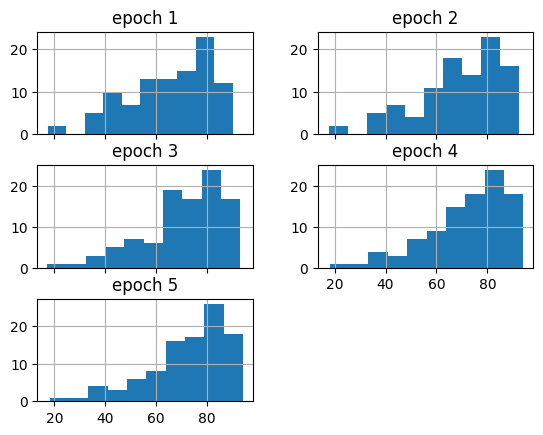

In [50]:
test_acc_df.hist(sharex=True)

In [21]:
zero_count_df.describe()

,before training,after training
count,100.000000,1.000000e+02
mean,461357.800000,1.253649e+06
std,37595.180659,1.202123e+05
min,391695.000000,9.024360e+05
25%,432785.750000,1.184672e+06
50%,457872.500000,1.255106e+06
75%,485229.750000,1.325076e+06
max,560769.000000,1.533398e+06


In [28]:
train_df.describe()

,epoch 1,epoch 2,epoch 3,epoch 4,epoch 5
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.280343,0.943009,0.859381,0.811886,0.778740
std,0.370091,0.420091,0.425305,0.424994,0.425545
min,0.612871,0.313995,0.253528,0.221083,0.199344
25%,0.958479,0.576462,0.506661,0.468723,0.443904
50%,1.255997,0.957889,0.878361,0.853619,0.707720
75%,1.504507,1.199988,1.138930,1.103413,1.074631
max,2.238867,2.159352,2.136415,2.131501,2.127966


In [32]:
train_df.describe().loc['mean'].to_numpy()

array([1.28034285, 0.94300943, 0.85938061, 0.81188638, 0.77874003])

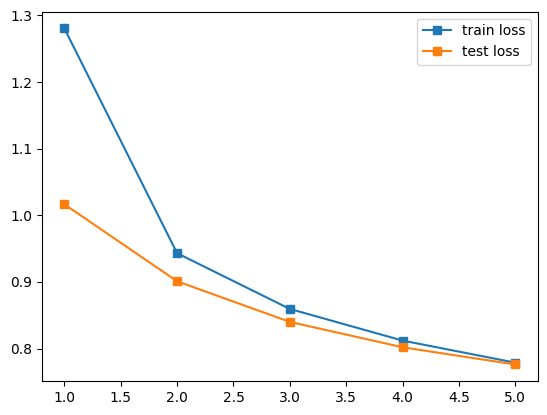

In [49]:
import matplotlib.pyplot as plt
plt.plot([x + 1 for x in range(5)], train_df.describe().loc['mean'].to_numpy(), label='train loss', marker="s")
plt.plot([x + 1 for x in range(5)], test_loss_df.describe().loc['mean'].to_numpy(), label='test loss', marker="s")
plt.legend()

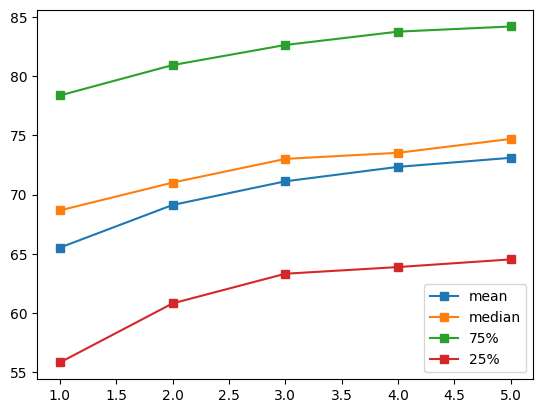

In [55]:
plt.plot([x + 1 for x in range(5)], test_acc_df.describe().loc['mean'].to_numpy(), label='mean', marker="s")
plt.plot([x + 1 for x in range(5)], test_acc_df.describe().loc['50%'].to_numpy(), label='median', marker="s")
plt.plot([x + 1 for x in range(5)], test_acc_df.describe().loc['75%'].to_numpy(), label='75%', marker="s")
plt.plot([x + 1 for x in range(5)], test_acc_df.describe().loc['25%'].to_numpy(), label='25%', marker="s")
plt.legend()